<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/nn_from_scratch_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get MNIST Data

In [ ]:
import torch
from torchvision.datasets import MNIST
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mnist_dataset = MNIST(root = './',
      train = True,
      transform = None,
      target_transform = None,
      download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 23596848.01it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19246217.64it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25279783.15it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13549451.47it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Helper functions

In [ ]:
# from mnist_get_data import extract_mnist
# this is custom function for extracting mnist images and labesl from ubyte files
def extract_mnist(image_f, label_f):
	'''
	This function is used to extract image files and the corresponding labels from ubyte format and save them in seperate directory.
	Source: https://gist.github.com/fukuroder/caa351677bf718a8bfe6265c2a45211f
	P.S. - The source of the code is not working due to some bugs. This function has modifications to work as per my liking.
	Parameters:
	image_f - full-path to the uncompressed images file
	labels_f - full-path to the uncompressed labels file

	Returns:
	None
	'''
	with open(image_f, 'rb') as f:
		images = f.read()
	with open(label_f, 'rb') as f:
		labels = f.read()

	images = [d for d in images[16:]]
	images = np.array(images, dtype=np.uint8)
	images = images.reshape((-1,28,28))

	outdir = image_f + "_folder"
	if not os.path.exists(outdir):
		os.mkdir(outdir)
	for k,image in enumerate(images):
		cv2.imwrite(os.path.join(outdir, '%05d.png' % (k,)), image)

	labels = ['%05d.png %d' % (k, l) for k,l in enumerate(labels[8:])]
	with open('%s.txt' % label_f, 'w') as f:
		f.write(os.linesep.join(labels))

In [ ]:
def process_mnist(img_path, label_file):
    '''
    Takes in image_directory and label_file_path and returns np.array's
    '''
    with open(label_file, mode='r') as f:
        filelines = f.readlines()
    label_dic = {}
    for line in filelines:
        key, value = line.split(sep=" ")
        label_dic[key] = int(value.removesuffix('\n'))

    imgs = []
    labels = []

    for filename in os.listdir(img_path):
        img = cv2.imread(os.path.join(img_path, filename), cv2.IMREAD_ANYCOLOR)
        imgs.append(img)

        labels.append(label_dic[filename])

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [ ]:
def calculate_metrics(confusion_matrix):
    # Assuming confusion_matrix is a 2D list of shape (num_classes, num_classes)
    num_classes = len(confusion_matrix)

    # Calculate true positives, false positives, false negatives, and true negatives for each class
    tp = [confusion_matrix[i][i] for i in range(num_classes)]
    fp = [sum(confusion_matrix[j][i] for j in range(num_classes) if j != i) for i in range(num_classes)]
    fn = [sum(confusion_matrix[i][j] for j in range(num_classes) if j != i) for i in range(num_classes)]
    tn = [sum(confusion_matrix[i][j] for j in range(num_classes) for i in range(num_classes)) - tp[i] - fp[i] - fn[i] for i in range(num_classes)]

    # Calculate accuracy for each class
    accuracy = [((tp[i] + tn[i]) / (tp[i] + fp[i] + fn[i] + tn[i])) if (tp[i] + fp[i] + fn[i] + tn[i]) != 0 else 0 for i in range(num_classes)]

    # Calculate precision for each class
    precision = [tp[i] / (tp[i] + fp[i]) if (tp[i] + fp[i]) != 0 else 0 for i in range(num_classes)]

    # Calculate recall for each class
    recall = [tp[i] / (tp[i] + fn[i]) if (tp[i] + fn[i]) != 0 else 0 for i in range(num_classes)]

    # Calculate F1-score for each class
    f_score = [2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0 for i in range(num_classes)]

    # Calculate micro-averaged metrics
    micro_accuracy = sum(tp) / (sum(tp) + sum(fp) + sum(fn) + sum(tn)) if (sum(tp) + sum(fp) + sum(fn) + sum(tn)) != 0 else 0
    micro_precision = sum(tp) / (sum(tp) + sum(fp)) if (sum(tp) + sum(fp)) != 0 else 0
    micro_recall = sum(tp) / (sum(tp) + sum(fn)) if (sum(tp) + sum(fn)) != 0 else 0
    micro_f_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) != 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f_score,
        "Micro Accuracy": micro_accuracy,
        "Micro Precision": micro_precision,
        "Micro Recall": micro_recall,
        "Micro F1-Score": micro_f_score
    }

In [ ]:
def create_val_split(x_train, y_train):
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  idx = np.arange(0, 60_000)
  np.random.shuffle(idx)
  # idx
  x_val = x_train[idx[50_000:]]
  y_val = y_train[idx[50_000:]]

  x_train = x_train[idx[:50_000]]
  y_train = y_train[idx[:50_000]]

  return x_train, y_train, x_val, y_val

# Prepare dataset

In [ ]:
train_image = './MNIST/raw/train-images-idx3-ubyte'
train_label = './MNIST/raw/train-labels-idx1-ubyte'
test_image = './MNIST/raw/t10k-images-idx3-ubyte'
test_label = './MNIST/raw/t10k-labels-idx1-ubyte'

In [ ]:
for image_f, label_f in [(train_image, train_label), (test_image, test_label)]:
    extract_mnist(image_f, label_f)

In [ ]:
train_img_path = './MNIST/raw/train-images-idx3-ubyte_folder'
train_label_file = './MNIST/raw/train-labels-idx1-ubyte.txt'
test_img_path = './MNIST/raw/t10k-images-idx3-ubyte_folder'
test_label_file = './MNIST/raw/t10k-labels-idx1-ubyte.txt'

In [ ]:
train_x, train_y = process_mnist(train_img_path, train_label_file)
test_x, test_y = process_mnist(test_img_path, test_label_file)

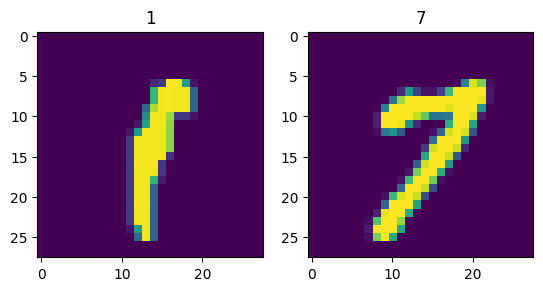

In [ ]:
idx = np.random.randint(0, 60_000)
plt.subplot(1, 2, 1)
plt.imshow(train_x[idx])
plt.title(train_y[idx])

idx = np.random.randint(0, 10_000)
plt.subplot(1, 2, 2)
plt.imshow(test_x[idx])
plt.title(test_y[idx])

plt.show()

# Define one layer classifier

In [ ]:
# from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
seed = 1342869
# seed = np.random.randint(10000000)
# seed

In [ ]:
class fcnn:
    def __init__(self,
                 node_layers = [2, 3, 3],
                 n_hidden_layers = 1,
                 learning_rate = 0.25,
                 tol = 1e-3,
                 max_epoch = 1000,
                 output_activation = 'sigmoid'):
        '''
        Parameters:
        node_layer: Number of nodes per layer, input layer + all hidden + output layer
        n_hidden_layer: Number of hidden layers in the network
        learning_rate: Constant learning rate
        tol: Tolerance of error between consequtive epochs
        max_epoch: Max number of epochs for training
        output_activation: To define the output activation function

        Returns:
        None
        '''
        self.learning_rate = learning_rate
        self.tol = tol
        self.max_epoch = max_epoch
        self.output_activation = output_activation
        self.input_dim = node_layers[0]
        self.nodes_h_dim = node_layers[1]
        self.output_dim = node_layers[-1]
        # initializing weights
        self.Wh = np.random.randn(self.input_dim+1, self.nodes_h_dim) # a = W.T @ x; rows of Wh is the dimention of input
        self.Wo = np.random.randn(self.nodes_h_dim, self.output_dim) # a = W.T @ x; rows of Wh is the dimention of input
        return None

    def logistic_sigmoid(self, x):
        '''
        Logistic sigmoidal function
        '''
        return 1/(1+np.exp(-x))

    def inst_err(self, y, y_hat):
        '''
        Return the instantaneous error for each example
        '''
        return 0.5*(y-y_hat)**2

    def forward_propagate(self, x):
        '''
        Computer the output of the network for a given example propagating forward in the network

        Parameter:
        Sample input vector

        Return:
        ho, h1 (returns in reverse order of operation)
        '''
        # input layer
        x_hat = np.concatenate(([1], x)) # augmenting the input vector

        # hidden layer
        a1 = np.matmul(self.Wh.T, x_hat) # hidden layer activation value
        h1 = self.logistic_sigmoid(a1) # hidden layer signal

        #output layer
        ao = np.matmul(self.Wo.T, h1) # output layer activation value
        if self.output_activation == "sigmoid":
            ho = self.logistic_sigmoid(ao) # output layer signal
        elif self.output_activation == "linear":
            ho = ao

        return ho, ao, h1, a1

    def backward_propagate(self, ho, h1, label, sample):
        x_hat = np.concatenate(([1], sample)) # augmenting the input vector
        if self.output_activation == "sigmoid":
            delta_o = ((label-ho)*ho*(1-ho))
        elif self.output_activation == "linear":
            delta_o = (label-ho)

        delta_h = np.matmul(self.Wo, delta_o)*h1*(1-h1)
        self.update(delta_o, x_hat, delta_h, h1)
        # return delta_o, delta_h

    def update(self, delta_o, x_hat, delta_h, h1):
        self.Wo += self.learning_rate * np.outer(h1, delta_o)
        self.Wh += self.learning_rate*np.outer(x_hat, delta_h)

    def fit(self, datas, labels, valid_data, valid_labels):
        '''
        This method fits the model to the required data
        '''
        err_epoch = []
        valid_loss_epoch = []
        # run epochs; stopping criteria 1
        # valid_pred_labels = []
        for epoch in range(self.max_epoch):
            print("Epoch: ", epoch)
            err = [] # store instantaneous error per example
            for i in tqdm(range(len(datas))): # show label and data of each class
                label, sample = labels[i], datas[i]
                # forward propagate through the network
                ho, _, h1, _ = self.forward_propagate(sample)
                err.append(self.inst_err(label, ho)) # store instantenous error of each example

                # update processs
                self.backward_propagate(ho, h1, label, sample)
            err_epoch.append(np.average(err)) # store average error per epoch

            # find validation loss after each epoch
            valid_loss_this_epoch = []
            for label, sample in zip(valid_labels, valid_data):
                ho, _, _, _ = self.forward_propagate(sample)
                valid_loss_this_epoch.append(np.average(self.inst_err(label, ho)))
            valid_loss_epoch.append(np.average(valid_loss_this_epoch))
            print(f"Train loss: {err_epoch[-1]}, Val loss: {valid_loss_epoch[-1]}")

        return err_epoch, valid_loss_epoch

    def fit_classifier(self, x_train, y_train, x_val, y_val):
      '''
         This methods fits the model for classification
      '''
      # one_hot_coder
      labels = {}
      for i in range(10):
        one_hot =  np.zeros((10))
        one_hot[i] = 1
        labels[i] = one_hot

      y_train = [labels[y] for y in y_train]
      y_val = [labels[y] for y in y_val]

      x_train = np.reshape(x_train, (-1, 28*28))
      x_val = np.reshape(x_val, (-1, 28*28))


      return self.fit(x_train, y_train, x_val, y_val)

    def predict(self, sample):
        ho, _, _, _ = self.forward_propagate(sample)
        return np.argmax(ho)


In [ ]:
# validation split
x_test = np.array(test_x)
y_test = np.array(test_y)
x_train, y_train, x_val, y_val = create_val_split(train_x, train_y)

In [ ]:
# Normalization
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

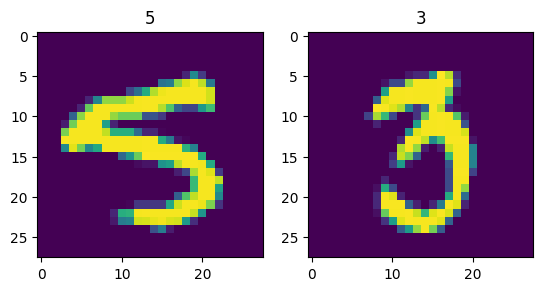

In [ ]:
idx = np.random.randint(0, 50_000)
plt.subplot(1, 2, 1)
plt.imshow(x_train[idx])
plt.title(y_train[idx])

idx = np.random.randint(0, 10_000)
plt.subplot(1, 2, 2)
plt.imshow(x_val[idx])
plt.title(y_val[idx])

plt.show()

In [ ]:
max_epoch = 100
neta = 0.05
classifier = fcnn(
    node_layers=[28*28, 20, 10],
    max_epoch=max_epoch,
    learning_rate=neta,
)

In [ ]:
train_loss, val_loss = classifier.fit_classifier(x_train, y_train, x_val, y_val)

Epoch:  0


100%|██████████| 50000/50000 [00:12<00:00, 4081.97it/s]


Train loss: 0.02594311345133301, Val loss: 0.015535904597013697
Epoch:  1


100%|██████████| 50000/50000 [00:12<00:00, 3948.88it/s]


Train loss: 0.012982327277135918, Val loss: 0.011175550966529807
Epoch:  2


100%|██████████| 50000/50000 [00:13<00:00, 3761.44it/s]


Train loss: 0.010148304105722655, Val loss: 0.009569011990904014
Epoch:  3


100%|██████████| 50000/50000 [00:10<00:00, 4816.55it/s]


Train loss: 0.008845024831189931, Val loss: 0.008775974232490054
Epoch:  4


100%|██████████| 50000/50000 [00:10<00:00, 4769.88it/s]


Train loss: 0.008054880357202043, Val loss: 0.008232345857819878
Epoch:  5


100%|██████████| 50000/50000 [00:13<00:00, 3812.68it/s]


Train loss: 0.007511912119723862, Val loss: 0.00785906290669599
Epoch:  6


100%|██████████| 50000/50000 [00:13<00:00, 3690.57it/s]


Train loss: 0.007122105873046243, Val loss: 0.0075790259380705775
Epoch:  7


100%|██████████| 50000/50000 [00:13<00:00, 3746.54it/s]


Train loss: 0.0068188506722939735, Val loss: 0.007372047242444941
Epoch:  8


100%|██████████| 50000/50000 [00:12<00:00, 4058.44it/s]


Train loss: 0.006565422102430546, Val loss: 0.007208581051109641
Epoch:  9


100%|██████████| 50000/50000 [00:09<00:00, 5404.61it/s]


Train loss: 0.006350095013289074, Val loss: 0.0070636338365803394
Epoch:  10


100%|██████████| 50000/50000 [00:13<00:00, 3826.13it/s]


Train loss: 0.006159320405342713, Val loss: 0.0069330307855705155
Epoch:  11


100%|██████████| 50000/50000 [00:12<00:00, 3867.94it/s]


Train loss: 0.005988223169239699, Val loss: 0.006821724464829425
Epoch:  12


100%|██████████| 50000/50000 [00:13<00:00, 3825.02it/s]


Train loss: 0.005835277561389689, Val loss: 0.006724635009758726
Epoch:  13


100%|██████████| 50000/50000 [00:10<00:00, 4564.31it/s]


Train loss: 0.0056991822833317544, Val loss: 0.006639244112587227
Epoch:  14


100%|██████████| 50000/50000 [00:10<00:00, 4788.93it/s]


Train loss: 0.005579637378934225, Val loss: 0.006568256767430968
Epoch:  15


100%|██████████| 50000/50000 [00:13<00:00, 3771.00it/s]


Train loss: 0.00547314735067547, Val loss: 0.006509719112925488
Epoch:  16


100%|██████████| 50000/50000 [00:13<00:00, 3822.54it/s]


Train loss: 0.005374430549484043, Val loss: 0.006460706316164061
Epoch:  17


100%|██████████| 50000/50000 [00:12<00:00, 3875.13it/s]


Train loss: 0.0052821235538367635, Val loss: 0.006417897997831231
Epoch:  18


100%|██████████| 50000/50000 [00:10<00:00, 4983.11it/s]


Train loss: 0.005194509117806581, Val loss: 0.006377767376995307
Epoch:  19


100%|██████████| 50000/50000 [00:10<00:00, 4574.81it/s]


Train loss: 0.005112737668335457, Val loss: 0.0063377087061020085
Epoch:  20


100%|██████████| 50000/50000 [00:12<00:00, 3902.71it/s]


Train loss: 0.0050357339823401594, Val loss: 0.006297772218005926
Epoch:  21


100%|██████████| 50000/50000 [00:13<00:00, 3841.39it/s]


Train loss: 0.004963862328249251, Val loss: 0.006259195872336188
Epoch:  22


100%|██████████| 50000/50000 [00:12<00:00, 4112.23it/s]


Train loss: 0.0048975610195622545, Val loss: 0.00622424635359736
Epoch:  23


100%|██████████| 50000/50000 [00:09<00:00, 5390.21it/s]


Train loss: 0.004834823607617463, Val loss: 0.006193498047705643
Epoch:  24


100%|██████████| 50000/50000 [00:12<00:00, 4091.14it/s]


Train loss: 0.004774989136643331, Val loss: 0.006166595579634006
Epoch:  25


100%|██████████| 50000/50000 [00:12<00:00, 3914.02it/s]


Train loss: 0.0047181106212573175, Val loss: 0.006144031375500577
Epoch:  26


100%|██████████| 50000/50000 [00:13<00:00, 3818.12it/s]


Train loss: 0.00466480315761329, Val loss: 0.006124584222857381
Epoch:  27


100%|██████████| 50000/50000 [00:11<00:00, 4504.80it/s]


Train loss: 0.004614626579261131, Val loss: 0.006105883023509227
Epoch:  28


100%|██████████| 50000/50000 [00:09<00:00, 5016.75it/s]


Train loss: 0.004567577525163176, Val loss: 0.006087249656911291
Epoch:  29


100%|██████████| 50000/50000 [00:13<00:00, 3840.40it/s]


Train loss: 0.004522810263587697, Val loss: 0.006069195100561835
Epoch:  30


100%|██████████| 50000/50000 [00:13<00:00, 3842.13it/s]


Train loss: 0.004479660481379292, Val loss: 0.006051507339409937
Epoch:  31


100%|██████████| 50000/50000 [00:13<00:00, 3803.19it/s]


Train loss: 0.00443819003283178, Val loss: 0.006033730889471084
Epoch:  32


100%|██████████| 50000/50000 [00:09<00:00, 5050.81it/s]


Train loss: 0.004398025411579299, Val loss: 0.006019220356065658
Epoch:  33


100%|██████████| 50000/50000 [00:11<00:00, 4496.00it/s]


Train loss: 0.0043598761920902295, Val loss: 0.006007049902943161
Epoch:  34


100%|██████████| 50000/50000 [00:13<00:00, 3830.00it/s]


Train loss: 0.004322832911918345, Val loss: 0.005994991810038672
Epoch:  35


100%|██████████| 50000/50000 [00:12<00:00, 3847.06it/s]


Train loss: 0.004286676539238007, Val loss: 0.005982457136411702
Epoch:  36


100%|██████████| 50000/50000 [00:12<00:00, 3990.98it/s]


Train loss: 0.0042516915498205556, Val loss: 0.005969112105997168
Epoch:  37


100%|██████████| 50000/50000 [00:09<00:00, 5372.84it/s]


Train loss: 0.004217894739861967, Val loss: 0.005955858481038126
Epoch:  38


100%|██████████| 50000/50000 [00:12<00:00, 4082.72it/s]


Train loss: 0.004185941828585786, Val loss: 0.0059427568943068235
Epoch:  39


100%|██████████| 50000/50000 [00:12<00:00, 3956.32it/s]


Train loss: 0.004155320718760328, Val loss: 0.005929066681420685
Epoch:  40


100%|██████████| 50000/50000 [00:13<00:00, 3813.99it/s]


Train loss: 0.00412539447058593, Val loss: 0.005915752561498533
Epoch:  41


100%|██████████| 50000/50000 [00:11<00:00, 4382.38it/s]


Train loss: 0.004096750527623858, Val loss: 0.0059028739663079125
Epoch:  42


100%|██████████| 50000/50000 [00:09<00:00, 5124.69it/s]


Train loss: 0.004068990281944313, Val loss: 0.005891443544443622
Epoch:  43


100%|██████████| 50000/50000 [00:13<00:00, 3837.84it/s]


Train loss: 0.004041416773474128, Val loss: 0.005882577743664562
Epoch:  44


100%|██████████| 50000/50000 [00:12<00:00, 3885.79it/s]


Train loss: 0.004014773602290444, Val loss: 0.005874259416747327
Epoch:  45


100%|██████████| 50000/50000 [00:12<00:00, 3851.16it/s]


Train loss: 0.003989401164129459, Val loss: 0.005865559729392099
Epoch:  46


100%|██████████| 50000/50000 [00:10<00:00, 4890.53it/s]


Train loss: 0.003965106076586173, Val loss: 0.005856375067791656
Epoch:  47


100%|██████████| 50000/50000 [00:11<00:00, 4527.65it/s]


Train loss: 0.003941623334143018, Val loss: 0.005847018631961793
Epoch:  48


100%|██████████| 50000/50000 [00:12<00:00, 3906.01it/s]


Train loss: 0.003918624854825565, Val loss: 0.005838862454772731
Epoch:  49


100%|██████████| 50000/50000 [00:13<00:00, 3811.96it/s]


Train loss: 0.003896036300299014, Val loss: 0.005832039629584127
Epoch:  50


100%|██████████| 50000/50000 [00:12<00:00, 4103.39it/s]


Train loss: 0.003873888947970058, Val loss: 0.005825581897371242
Epoch:  51


100%|██████████| 50000/50000 [00:09<00:00, 5335.23it/s]


Train loss: 0.00385218108734379, Val loss: 0.005819547261730791
Epoch:  52


100%|██████████| 50000/50000 [00:12<00:00, 4010.82it/s]


Train loss: 0.0038306576716871966, Val loss: 0.005812909676674745
Epoch:  53


100%|██████████| 50000/50000 [00:13<00:00, 3770.99it/s]


Train loss: 0.003809077123256193, Val loss: 0.005805439521899532
Epoch:  54


100%|██████████| 50000/50000 [00:13<00:00, 3821.70it/s]


Train loss: 0.0037877267936233644, Val loss: 0.005797895927109325
Epoch:  55


100%|██████████| 50000/50000 [00:11<00:00, 4468.30it/s]


Train loss: 0.0037669434283328688, Val loss: 0.005790394854564714
Epoch:  56


100%|██████████| 50000/50000 [00:10<00:00, 4854.09it/s]


Train loss: 0.0037467155617755305, Val loss: 0.005782998142759775
Epoch:  57


100%|██████████| 50000/50000 [00:12<00:00, 3880.52it/s]


Train loss: 0.0037269198727095244, Val loss: 0.005775806575602165
Epoch:  58


100%|██████████| 50000/50000 [00:12<00:00, 3848.97it/s]


Train loss: 0.0037074732731330953, Val loss: 0.005769034909984509
Epoch:  59


100%|██████████| 50000/50000 [00:13<00:00, 3784.12it/s]


Train loss: 0.003688341373956617, Val loss: 0.005762782850329762
Epoch:  60


100%|██████████| 50000/50000 [00:10<00:00, 4554.37it/s]


Train loss: 0.0036694033397919952, Val loss: 0.005755877816119414
Epoch:  61


100%|██████████| 50000/50000 [00:10<00:00, 4844.71it/s]


Train loss: 0.00365093808118633, Val loss: 0.005748546987833552
Epoch:  62


100%|██████████| 50000/50000 [00:13<00:00, 3748.96it/s]


Train loss: 0.0036329615406813717, Val loss: 0.005742199781071982
Epoch:  63


100%|██████████| 50000/50000 [00:13<00:00, 3785.89it/s]


Train loss: 0.003615535630308226, Val loss: 0.005736856322713469
Epoch:  64


100%|██████████| 50000/50000 [00:13<00:00, 3790.09it/s]


Train loss: 0.0035985003085548155, Val loss: 0.005732389804321722
Epoch:  65


100%|██████████| 50000/50000 [00:10<00:00, 4650.33it/s]


Train loss: 0.003581859804538295, Val loss: 0.00572887702930596
Epoch:  66


100%|██████████| 50000/50000 [00:10<00:00, 4861.20it/s]


Train loss: 0.0035656224398999715, Val loss: 0.005726151818460302
Epoch:  67


100%|██████████| 50000/50000 [00:13<00:00, 3713.46it/s]


Train loss: 0.0035497545668623483, Val loss: 0.0057238326672449
Epoch:  68


100%|██████████| 50000/50000 [00:12<00:00, 3865.59it/s]


Train loss: 0.00353414909179506, Val loss: 0.0057217852543262285
Epoch:  69


100%|██████████| 50000/50000 [00:13<00:00, 3774.67it/s]


Train loss: 0.0035187374485376884, Val loss: 0.005720037286044218
Epoch:  70


100%|██████████| 50000/50000 [00:10<00:00, 4861.63it/s]


Train loss: 0.003503651128477645, Val loss: 0.005718352423567912
Epoch:  71


100%|██████████| 50000/50000 [00:10<00:00, 4576.16it/s]


Train loss: 0.003489929787096125, Val loss: 0.005717609888600595
Epoch:  72


100%|██████████| 50000/50000 [00:12<00:00, 3850.90it/s]


Train loss: 0.003474867730376826, Val loss: 0.005716429232971111
Epoch:  73


100%|██████████| 50000/50000 [00:13<00:00, 3768.73it/s]


Train loss: 0.0034605283838755117, Val loss: 0.005714083461914275
Epoch:  74


100%|██████████| 50000/50000 [00:13<00:00, 3751.17it/s]


Train loss: 0.0034468047919853383, Val loss: 0.005713102508505331
Epoch:  75


100%|██████████| 50000/50000 [00:09<00:00, 5012.51it/s]


Train loss: 0.003433905709621704, Val loss: 0.005712563268314902
Epoch:  76


100%|██████████| 50000/50000 [00:11<00:00, 4379.15it/s]


Train loss: 0.00342084968836159, Val loss: 0.0057126481308360745
Epoch:  77


100%|██████████| 50000/50000 [00:13<00:00, 3822.13it/s]


Train loss: 0.0034072902163183125, Val loss: 0.005713554406739682
Epoch:  78


100%|██████████| 50000/50000 [00:13<00:00, 3828.34it/s]


Train loss: 0.0033936979422294488, Val loss: 0.005715407362296619
Epoch:  79


100%|██████████| 50000/50000 [00:12<00:00, 3991.97it/s]


Train loss: 0.0033804694346972843, Val loss: 0.005717940601796125
Epoch:  80


100%|██████████| 50000/50000 [00:09<00:00, 5406.55it/s]


Train loss: 0.003367735995806709, Val loss: 0.005720631473329948
Epoch:  81


100%|██████████| 50000/50000 [00:12<00:00, 3949.04it/s]


Train loss: 0.0033552841247570376, Val loss: 0.005723204202650267
Epoch:  82


100%|██████████| 50000/50000 [00:13<00:00, 3777.19it/s]


Train loss: 0.0033429079617970296, Val loss: 0.005725455068461928
Epoch:  83


100%|██████████| 50000/50000 [00:13<00:00, 3755.76it/s]


Train loss: 0.003330591331993047, Val loss: 0.005727284959053259
Epoch:  84


100%|██████████| 50000/50000 [00:11<00:00, 4291.25it/s]


Train loss: 0.0033185119976838528, Val loss: 0.00572895093144876
Epoch:  85


100%|██████████| 50000/50000 [00:09<00:00, 5235.17it/s]


Train loss: 0.0033067472117879015, Val loss: 0.005731067949360052
Epoch:  86


100%|██████████| 50000/50000 [00:13<00:00, 3842.53it/s]


Train loss: 0.0032951851151930204, Val loss: 0.005733963101023691
Epoch:  87


100%|██████████| 50000/50000 [00:13<00:00, 3728.26it/s]


Train loss: 0.003283660227257992, Val loss: 0.005737740302390596
Epoch:  88


100%|██████████| 50000/50000 [00:12<00:00, 3859.95it/s]


Train loss: 0.003271816597442496, Val loss: 0.00574186047513777
Epoch:  89


100%|██████████| 50000/50000 [00:10<00:00, 4634.96it/s]


Train loss: 0.0032602421777452595, Val loss: 0.005745955321882245
Epoch:  90


100%|██████████| 50000/50000 [00:10<00:00, 4660.10it/s]


Train loss: 0.003249271620595065, Val loss: 0.0057506425009075796
Epoch:  91


100%|██████████| 50000/50000 [00:13<00:00, 3761.53it/s]


Train loss: 0.0032386273698371882, Val loss: 0.005755550010906928
Epoch:  92


100%|██████████| 50000/50000 [00:12<00:00, 3943.51it/s]


Train loss: 0.003228271207731706, Val loss: 0.005760376101945407
Epoch:  93


100%|██████████| 50000/50000 [00:12<00:00, 3866.08it/s]


Train loss: 0.0032180082808481517, Val loss: 0.005764065394843228
Epoch:  94


100%|██████████| 50000/50000 [00:09<00:00, 5268.46it/s]


Train loss: 0.0032076685356231057, Val loss: 0.005765161584235371
Epoch:  95


100%|██████████| 50000/50000 [00:11<00:00, 4222.17it/s]


Train loss: 0.0031977827399463335, Val loss: 0.005764985884055789
Epoch:  96


100%|██████████| 50000/50000 [00:13<00:00, 3800.85it/s]


Train loss: 0.003188078111456169, Val loss: 0.005764757418758157
Epoch:  97


100%|██████████| 50000/50000 [00:12<00:00, 3875.27it/s]


Train loss: 0.0031784379668022703, Val loss: 0.005764135884093324
Epoch:  98


100%|██████████| 50000/50000 [00:11<00:00, 4289.38it/s]


Train loss: 0.0031687910894326074, Val loss: 0.005762942592959868
Epoch:  99


100%|██████████| 50000/50000 [00:09<00:00, 5379.76it/s]


Train loss: 0.003159215051536512, Val loss: 0.0057610492982527


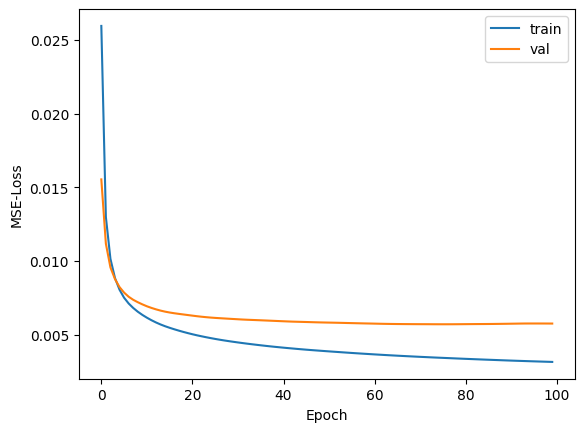

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.xlabel('Epoch')
plt.ylabel('MSE-Loss')
plt.show()

In [ ]:
y_test.shape, x_test.shape

((10000,), (10000, 28, 28))

In [ ]:
# Test and eval
conf_mat = np.zeros((10, 10), dtype=int)
for x, y in zip(x_test.reshape(-1, 28*28), y_test):
  y_hat = classifier.predict(x)
  conf_mat[y, y_hat] += 1
print(conf_mat)

[[ 959    0    4    2    1    2    6    3    2    1]
 [   0 1108    6    2    0    4    4    1   10    0]
 [  13    4  958   12   13    0    6   15   10    1]
 [   4    0   19  929    1   19    0   11   23    4]
 [   1    0    7    1  931    2   12    4    1   23]
 [  11    2    5   37    8  795   13    4   12    5]
 [  15    2    9    0    6   10  908    0    8    0]
 [   6    9   21    5    6    2    0  955    5   19]
 [   7    3    6   28    3   11   10   12  893    1]
 [   8    5    1   19   42    5    0   18   15  896]]


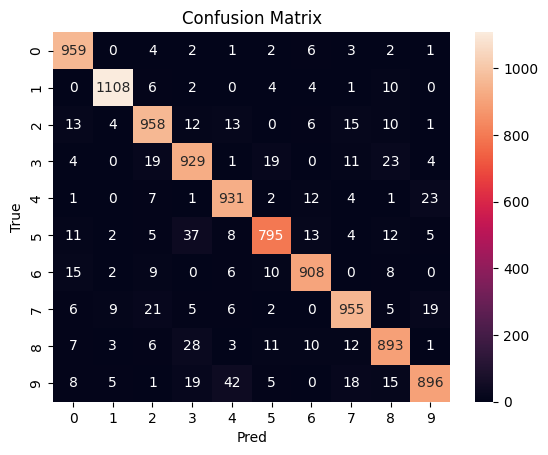

Accuracy: 0.987
Precision: 0.933
Recall: 0.932
F1-Score: 0.932


In [ ]:
import seaborn as sns

plt.title("Confusion Matrix")
# plt.matshow(conf_mat cmap="gray")
# plt.xticks(range(10))
# plt.yticks(range(10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

metrics = calculate_metrics(conf_mat)
print(f"Accuracy: {np.mean(metrics['Accuracy']):.3f}")
print(f"Precision: {np.mean(metrics['Precision']):.3f}")
print(f"Recall: {np.mean(metrics['Recall']):.3f}")
print(f"F1-Score: {np.mean(metrics['F1-Score']):.3f}")
